<hr />
<h1 align="center">Using ArcticDB for equity analytics: a worked example</h1>
<center><img src="https://raw.githubusercontent.com/man-group/ArcticDB/master/static/ArcticDBCropped.png" alt="ArcticDB Logo" width="400">
<hr />

### A Simple Workflow for Equity Price Timeseries

In this notebook we:

* Source historical tech equity and S&P 500 prices from Yahoo! using the yfinance package
* Store 10 years of daily price raw data in a temporary local ArcticDB library set up in the notebook
* The data sourcing is broken into two steps: an initial load of history then an update for recent prices
* This suggests a typical system workflow: an initial backfill and daily update with recent data
* Take Adjusted Close prices, remove missing data and calculate returns. Then save this to library
* Read the clean returns and use them to calculate rolling beta against the S&P 500 for the stocks

### Notice: This notebook sources data from Yahoo!

Please read Yahoo terms here before using it

https://policies.yahoo.com/us/en/yahoo/terms/index.htm

### Installs and Imports

In [2]:
!pip install arcticdb yfinance

In [3]:
import arcticdb as adb
import yfinance as yf
import pandas as pd
from typing import List, Tuple
from datetime import datetime 
import matplotlib.pyplot as plt 

### ArcticDB Setup

In [4]:
arctic = adb.Arctic("lmdb://arcticdb_equity")
lib = arctic.get_library('demo', create_if_missing=True)

### Source Historical Prices from Yahoo!

In [24]:
start = datetime(2013, 1, 1) 
end = datetime(2022, 12, 31)
freq = '1d'
symbols = {
    '^GSPC': 'S&P 500',
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOG': 'Google',
    'AMZN': 'Amazon',
    'NVDA': 'Nvidia',
    'META': 'Meta',
    'TSLA': 'Tesla',
    'TSM': 'TSMC',
    'TCEHY': 'Tencent',
    '005930.KS': 'Samsung',
    'ORCL': 'Oracle',
    'ADBE': 'Adobe',
    'ASML': 'ASML',
    'CSCO': 'Cisco'
}

In [25]:
hist = yf.download(list(symbols.keys()), interval=freq, start=start, end=end)

[*********************100%%**********************]  15 of 15 completed


In [26]:
# the column levels[0] are the fields for each stock
print(hist.columns.levels[0])
hist['Volume'].head(5)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


005930.KS         AAPL       ADBE        AMZN       ASML  \
Date                                                                    
2013-01-02  11449650.0  560518000.0  6483800.0  65420000.0  1824000.0   
2013-01-03  14227400.0  352965200.0  3906000.0  55018000.0  1725400.0   
2013-01-04  12999800.0  594333600.0  3809300.0  37484000.0  3170800.0   
2013-01-07  12610950.0  484156400.0  3632100.0  98200000.0  2066100.0   
2013-01-08  13822250.0  458707200.0  3080900.0  60214000.0  1182400.0   

                  CSCO         GOOG        META        MSFT        NVDA  \
Date                                                                      
2013-01-02  40304500.0  102033017.0  69846400.0  52899300.0  47883600.0   
2013-01-03  50603500.0   93075567.0  63140600.0  48294400.0  29888800.0   
2013-01-04  36378900.0  110954331.0  72715400.0  52521100.0  52496800.0   
2013-01-07  30790700.0   66476239.0  83781800.0  37110400.0  61073200.0   
2013-01-08  33218100.0   67295297.0  45871300.0  44703100.0  46642400.0   

                  ORCL     TCEHY        TSLA         TSM         ^GSPC  
Date                                                                    
2013-01-02  33758400.0  362500.0  17922000.0  10226100.0  4.202600e+09  
2013-01-03  21819500.0  355000.0  11130000.0  13148600.0  3.829730e+09  
2013-01-04  21687300.0  101000.0  10110000.0   7464200.0  3.424290e+09  
2013-01-07  14008300.0   83000.0   6630000.0   9429900.0  3.304970e+09  
2013-01-08  17408900.0   49000.0  19260000.0   8112900.0  3.601600e+09

### Write the Data to the Library

Currently ArcticDB cannot store multi-level column dataframes directly, so we use a symbol for each price field.

In [27]:
def field_name_to_sym(field_name: str) -> str:
    return f"hist/price_{field_name.replace(' ', '')}"

In [28]:
for l in hist.columns.levels[0]:
    lib.write(field_name_to_sym(l), hist[l])

In [29]:
# read back and check that the data round-trips precisely
for l in hist.columns.levels[0]:
    hist_check_db = lib.read(field_name_to_sym(l)).data
    if not hist[l].equals(hist_check_db):
        print(f"Field '{l}' does not round-trip")

### Update with Recent Data

Here we consume data for the recent past and slightly overlap the time window with the original data.

In a real workflow this technique can be used to apply restatements to the price dataset.

In [30]:
update_start = datetime(2022, 7, 1) 
update_end = datetime(2023, 12, 31)
update_hist = yf.download(list(symbols.keys()), interval=freq, start=update_start, end=update_end)

[*********************100%%**********************]  15 of 15 completed


In [31]:
for l in update_hist.columns.levels[0]:
    lib.update(field_name_to_sym(l), update_hist[l])

In [32]:
# these are the symbols we have created
lib.list_symbols()

['hist/price_High',
 'hist/price_Low',
 'hist/price_Volume',
 'hist/price_Close',
 'hist/price_AdjClose',
 'hist/price_Open']

In [33]:
# each symbol contains data for one price field, with the stock tickers as columns and dates as the index
lib.read(field_name_to_sym('Close')).data.head()

005930.KS       AAPL       ADBE     AMZN       ASML       CSCO  \
Date                                                                         
2013-01-02    31520.0  19.608213  38.340000  12.8655  66.779999  20.340000   
2013-01-03    30860.0  19.360714  37.750000  12.9240  65.379997  20.450001   
2013-01-04    30500.0  18.821428  38.130001  12.9575  64.709999  20.480000   
2013-01-07    30400.0  18.710714  37.939999  13.4230  63.660000  20.290001   
2013-01-08    30000.0  18.761070  38.139999  13.3190  63.139999  20.309999   

                 GOOG       META       MSFT    NVDA       ORCL  TCEHY  \
Date                                                                    
2013-01-02  18.013729  28.000000  27.620001  3.1800  34.689999  6.720   
2013-01-03  18.024191  27.770000  27.250000  3.1825  34.310001  6.660   
2013-01-04  18.380356  28.760000  26.740000  3.2875  34.610001  6.694   
2013-01-07  18.300158  29.420000  26.690001  3.1925  34.430000  6.600   
2013-01-08  18.264042  29.059999  26.549999  3.1225  34.439999  6.570   

                TSLA        TSM        ^GSPC  
Date                                          
2013-01-02  2.357333  18.100000  1462.420044  
2013-01-03  2.318000  18.090000  1459.369995  
2013-01-04  2.293333  17.959999  1466.469971  
2013-01-07  2.289333  17.700001  1461.890015  
2013-01-08  2.245333  17.540001  1457.150024

### Read and Process the Whole Price Dataset

* Read the data, using the *Adj Close* field as our primary price source
* Remove missing data by forward filling. A simple but unsophisticated method
* Calculate daily returns from the prices
* Write the returns back to ArcticDB as another symbol

In [36]:
hist_adj_close = lib.read(field_name_to_sym('Adj Close')).data

In [37]:
# ffill to remove nans (missing data)
hist_adj_close_clean = hist_adj_close.ffill()
# the following line will return True if there are any nans
hist_adj_close_clean.isnull().any().any()

False

In [38]:
hist_daily_returns = hist_adj_close_clean.pct_change(1).iloc[1:]
hist_daily_returns.iloc[:5, :5]

005930.KS      AAPL      ADBE      AMZN      ASML
Date                                                         
2013-01-03  -0.020939 -0.012622 -0.015389  0.004547 -0.020964
2013-01-04  -0.011666 -0.027854  0.010066  0.002592 -0.010248
2013-01-07  -0.003278 -0.005882 -0.004983  0.035925 -0.016226
2013-01-08  -0.013158  0.002691  0.005272 -0.007748 -0.008168
2013-01-09   0.000000 -0.015629  0.013634 -0.000113  0.005702

In [40]:
returns_sym = 'hist/returns_AdjClose_clean'
lib.write(returns_sym, hist_daily_returns)

VersionedItem(symbol='hist/returns_AdjClose_clean', library='demo', data=n/a, version=1, metadata=None, host='LMDB(path=/users/isys/nclarke/jupyter/arctic/demos/arcticdb_equity)')

### End of the Data Processing - Make a Snapshot

The snapshot is optional but it can be useful to record the state of all the data and the end of the daily update process.

In [41]:
snapshot_name = f"eod:{hist_daily_returns.iloc[-1].name.date()}"
print(snapshot_name)
if snapshot_name in lib.list_snapshots():
    lib.delete_snapshot(snapshot_name)
lib.snapshot(snapshot_name, metadata="EOD audit point")

eod:2023-11-17


### Visualise the Returns

<Axes: title={'center': 'Daily Cumulative Stock Returns'}, xlabel='Date'>

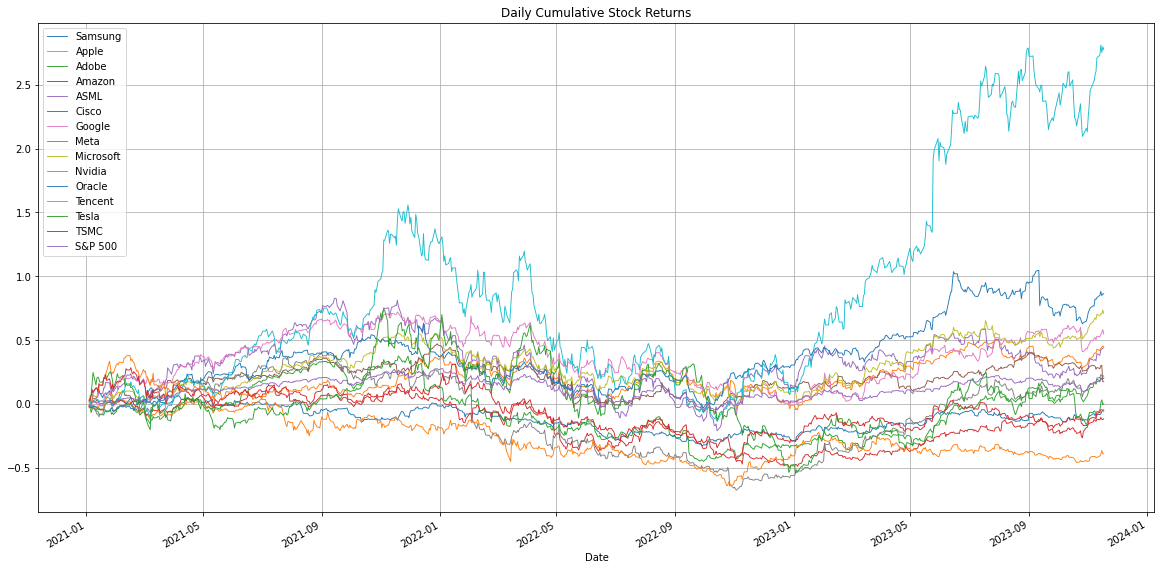

In [42]:
plot_start = datetime(2021, 1, 1)
plot_end = datetime(2023, 12, 31)
returns_plot = lib.read(returns_sym, date_range=(plot_start, plot_end)).data
daily_cum_returns = ((1 + returns_plot).cumprod() - 1)
daily_cum_returns.rename(columns=symbols).plot(figsize=(20, 10), grid=True, linewidth=0.9, title="Daily Cumulative Stock Returns")

### Analysis: Compute Rolling Betas vs the S&P 500

Notice the big change in betas starting in Q2 2020 which rolls out of the betas 130 days later (the size of the rolling window).

Possibly due to the large market moves at the start of the Covid era?

In [43]:
index_ticker = "^GSPC"
roll_days = 130
beta_start = datetime(2018, 1, 1)
beta_end = datetime(2022, 12, 31)
beta_returns = lib.read(returns_sym, date_range=(beta_start, beta_end)).data
index_returns = beta_returns[index_ticker]
stock_returns = beta_returns.drop(columns=index_ticker)

In [44]:
rolling_cov = stock_returns.rolling(roll_days).cov(index_returns).iloc[roll_days-1:]
rolling_index_var = index_returns.rolling(roll_days).var().iloc[roll_days-1:]
rolling_beta = rolling_cov.divide(rolling_index_var, axis='index').rename(columns=symbols)

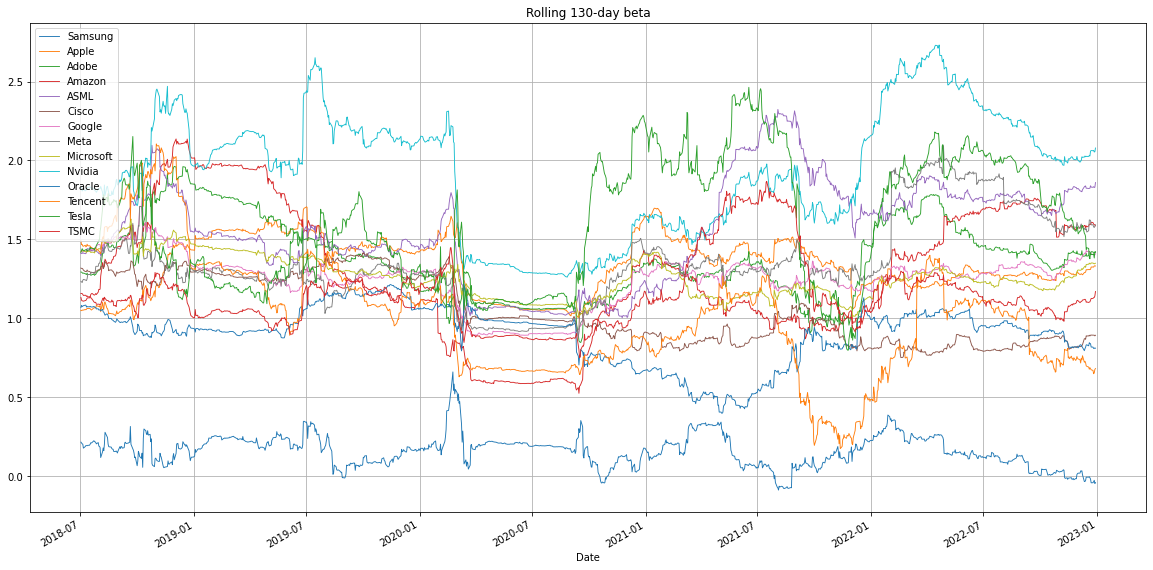

In [45]:
ax = rolling_beta.plot(figsize=(20, 10), grid=True, linewidth=0.9, title=f"Rolling {roll_days}-day beta")
ax.legend(loc='upper left')

### Conclusions

* We have demonstrated a simple data pipeline for capture and analysis
* Although simple, this pattern scales well to much larger datasets
* In a real system, the data collection and storage would be separated from the analysis
* Throughout the ArcticDB usage is simple, clean and clear
* Researchers and Data Scientists like the simplicity - it allows them to focus on the data and their research

For more information about equity beta see https://en.wikipedia.org/wiki/Beta_(finance)